In [62]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?
#rcParams['figure.figsize'] = 11,8
plt.gray() #Ensures greyscale images are displayed gray without having to use cmap parameter

<Figure size 432x288 with 0 Axes>

## Functions

In [63]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

In [64]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    # #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [65]:
#Converts images to grayscale
# Implented during in class labs
def img2grayscale(img):
    # img = img.astype(np.float32)/255
    # img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3
    img_gr = img.copy()
    img_gr = cv2.cvtColor(img_gr, cv2.COLOR_BGR2GRAY)
    return img_gr

In [66]:
##This is provided by the A4 document!!

import numpy as np

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))


## Part 1

### Load in Images

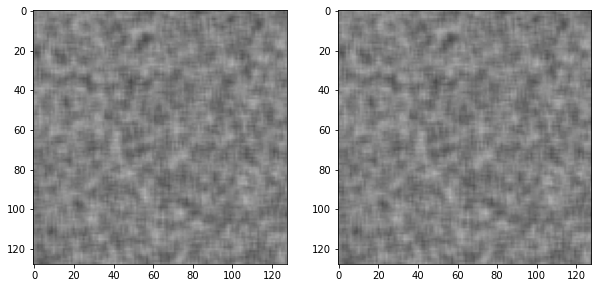

In [67]:
#Start with reading in images
synth0 = cv2.imread('Sequences/synth/synth_0.png')
#plt.imshow(synth1)
synth1 = cv2.imread('Sequences/synth/synth_0.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth0)
ax[1].imshow(synth1)

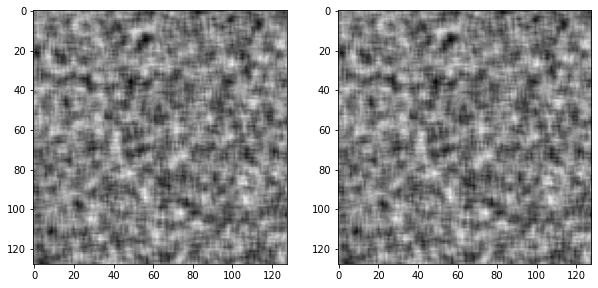

In [68]:
synth0_gr = img2grayscale(synth0)
synth1_gr = img2grayscale(synth1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth0_gr)
ax[1].imshow(synth1_gr)

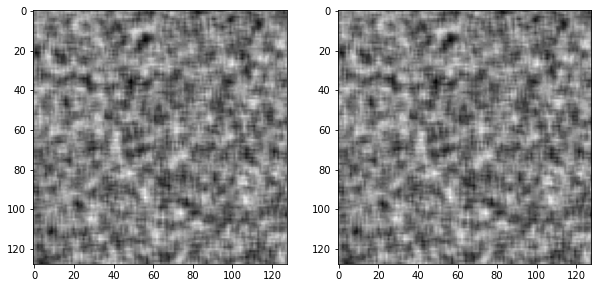

In [69]:
synth0_gr = synth0_gr.astype(np.float32)/255 
synth1_gr = synth1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth0_gr)
ax[1].imshow(synth1_gr)

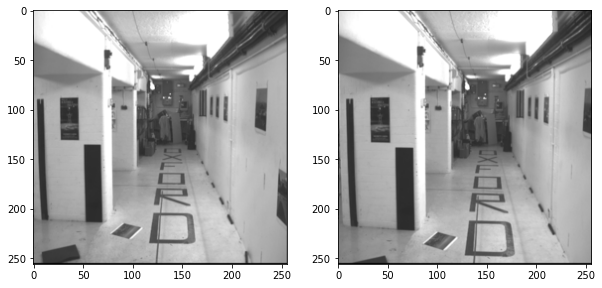

In [70]:
corridor0 = cv2.imread('Sequences/corridor/bt_0.png')
corridor1 = cv2.imread('Sequences/corridor/bt_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor0)
ax[1].imshow(corridor1)

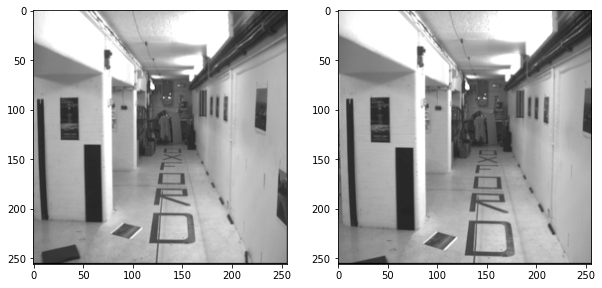

In [71]:
corridor0_gr = img2grayscale(corridor0)
corridor1_gr = img2grayscale(corridor1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor0_gr)
ax[1].imshow(corridor1_gr)

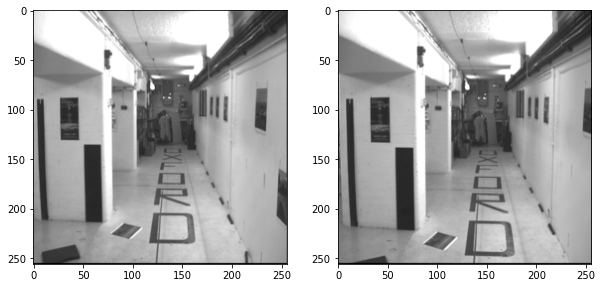

In [72]:
corridor0_gr = corridor0_gr.astype(np.float32)/255 
corridor1_gr = corridor1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor0_gr)
ax[1].imshow(corridor1_gr)

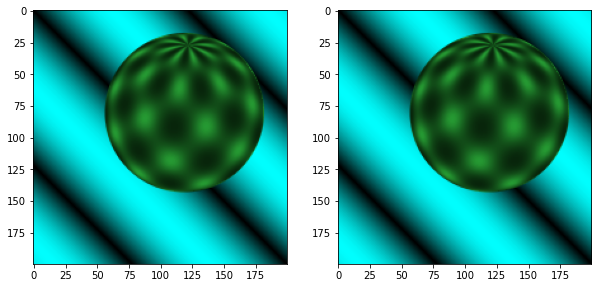

In [73]:
sphere0 = cv2.imread('Sequences/sphere/sphere_0.png')
sphere1 = cv2.imread('Sequences/sphere/sphere_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere0)
ax[1].imshow(sphere1)

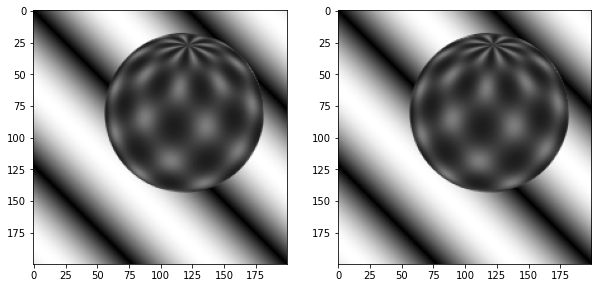

In [74]:
sphere0_gr = img2grayscale(sphere0)
sphere1_gr = img2grayscale(sphere1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

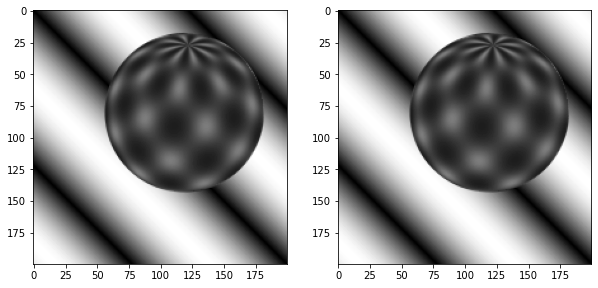

In [75]:
sphere0_gr = sphere0_gr.astype(np.float32)/255 
sphere1_gr = sphere1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

### Now compute flow

In [76]:
def myFlow(img1, img2, windowLength, tau):
    return 0

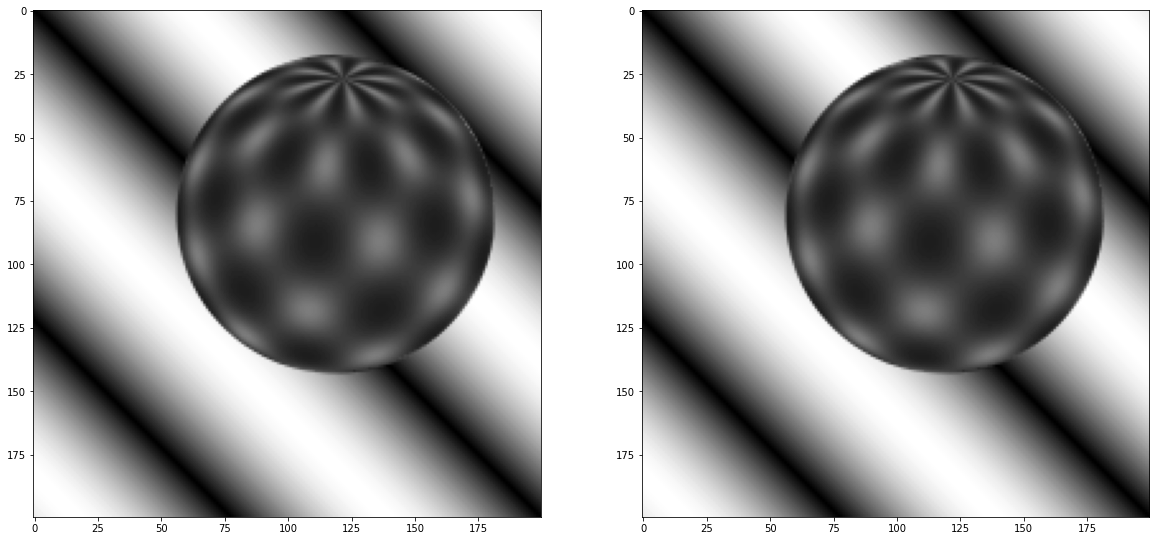

In [77]:
#To compute temporal derivative, apply gaussian filtering with a small sigma value (e.g. 3x3 filter with sigma = 1)
img0 = cv2.GaussianBlur(sphere0_gr, (3,3), sigmaX=1)
img1 = cv2.GaussianBlur(sphere1_gr, (3,3), sigmaX=1)

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

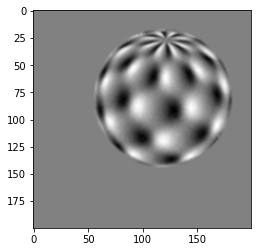

In [78]:
#Then subtract the first image from the second image
It = img1 - img0  #This is our It partial derivative
plt.imshow(It)

In [79]:
#CV2 filtering
#https://stackoverflow.com/questions/58477255/how-to-do-convolution-in-opencv

In [80]:
#To compute spatial derivatives, use the five tap derivative filter
fiveTap = [-1, 8, 0, -8, 1]
fiveTap = np.asarray(fiveTap) * (1/12)
fiveTap

array([-0.08333333,  0.66666667,  0.        , -0.66666667,  0.08333333])

In [81]:
fiveTap3 = [[-1, 8, 0, -8, 1]]
fiveTap3 = np.asarray(fiveTap3) * (1/12)
fiveTap3

array([[-0.08333333,  0.66666667,  0.        , -0.66666667,  0.08333333]])

In [82]:
#We can use scipy's signal.convolve2d to convolve our image and kernel
from scipy import signal

Ix = signal.convolve2d(sphere0_gr, fiveTap3)
print(Ix)

[[ 0.         -0.00130719  0.00686275 ... -0.47745099 -0.47026144
   0.06732026]
 [-0.00130719  0.01045752 -0.00130719 ... -0.48202615 -0.47745099
   0.06830065]
 [-0.00359477  0.02745098  0.01045752 ... -0.48692811 -0.48202615
   0.06895425]
 ...
 [-0.06895425  0.48202615  0.48692811 ... -0.01045752 -0.02745098
   0.00359477]
 [-0.06830065  0.47745099  0.48202615 ...  0.00130719 -0.01045752
   0.00130719]
 [-0.06732026  0.47026144  0.47745099 ... -0.00686275  0.00130719
   0.        ]]


In [83]:
fiveTap2 = np.vstack(fiveTap)
fiveTap2

array([[-0.08333333],
       [ 0.66666667],
       [ 0.        ],
       [-0.66666667],
       [ 0.08333333]])

In [84]:
Iy = signal.convolve2d(sphere0_gr, fiveTap2)
print(Iy)

[[ 0.         -0.00130719 -0.00359477 ... -0.06895425 -0.06830065
  -0.06732026]
 [-0.00130719  0.01045752  0.02745098 ...  0.48202615  0.47745099
   0.47026144]
 [ 0.00686275 -0.00130719  0.01045752 ...  0.48692811  0.48202615
   0.47745099]
 ...
 [-0.47745099 -0.48202615 -0.48692811 ... -0.01045752  0.00130719
  -0.00686275]
 [-0.47026144 -0.47745099 -0.48202615 ... -0.02745098 -0.01045752
   0.00130719]
 [ 0.06732026  0.06830065  0.06895425 ...  0.00359477  0.00130719
   0.        ]]
